In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [6]:
def idx_to_time(arr, samp_rate):
    print(len(arr))
    return np.arange(len(arr))/samp_rate 

In [7]:
samp_rate = 1e5
chirp_maxfreq = 1e3
pulse_T = 0.1

In [31]:
def matched_filter_sim(samp_rate, chirp_maxfreq, pulse_T, delay = 0, repeat = 0, wait = 0, 
                   wait_noise = (0,0), sig_noise = (0,0), plot = True):
    """
    Performs a matched filter simulation on a synthetic ramp-up chirp waveform of specified paameters 

    Parameters:
    
    samp_rate (int): Sample rate
    chirp_maxfreq (int) : Maximumf frequency in the chirp in Hz (minimum is 0)
    pulse_t (float) : Period of one chirp pulse in seconds
    delay (float): Desired delay between to pulses in seconds
    repeat (int): Number of chirps to be repeated
    pad (float): Number of seconds of zero padding before and after the chirp(s) in seconds
    wait (float): Delay between two sequential chirps in seconds
    wait_noise (tuple of floats): Standard deviation in the gaussian noise added to the wait time between pulses. 
                                  Two values needed
    sig_noise (tuple of floats): Standard devaition of gaussian noise added to both signals. Two values needed.
    

    Returns:
    """
    
    if chirp_maxfreq > samp_rate/2:
        raise ValueError("Sample rate too low for specified chirp frequency range")
    
    t_pts = samp_rate*pulse_T
    time = np.linspace(0, pulse_T, int(t_pts))

    chirp = scipy.signal.chirp(time, f0=0, f1=chirp_maxfreq, t1=pulse_T, method='linear')
    
    #ref_chirp = np.pad(chirp, (samp_rate*pad, samp_rate*pad), "constant", constant_values = (0,0))
    
    pad = delay*2

    # Repetition with no buffer between chirps
    if repeat > 0 and wait == 0 and wait_noise == 0:
        
        rep_chirp = np.tile(chirp, repeat)
        sig1 = (np.pad(rep_chirp, (int(samp_rate*pad), int(samp_rate*pad)), "constant", constant_values = (0,0)))
        sig2 = np.pad(rep_chirp, (int(samp_rate*pad), int(samp_rate*pad)), "constant", constant_values = (0,0))
    
    #Repetition with buffers
    if repeat > 0 and wait > 0 and wait_noise == 0: 
        
        buff = np.zeros(int(samp_rate*wait))
        chirp_wait = np.concatenate((chirp, buff))
        rep_chirp = np.concatenate((np.tile(chirp_wait, repeat-1), chirp))
        sig1 = np.pad(rep_chirp, (int(samp_rate*pad), int(samp_rate*pad)), "constant", constant_values = (0,0))
        sig2 = np.pad(rep_chirp, (int(samp_rate*pad + samp_rate*delay), int(samp_rate*pad - samp_rate*delay)),
                      "constant", constant_values = (0,0))
    
    #Repetition with noisy buffers
    if repeat > 0 and wait > 0 and wait_noise != 0: 

        rep_chirp = []
        for i in range(repeat):

            buff = np.zeros((int(samp_rate*wait + np.random.normal(loc = 0, scale = wait_noise))))
            chirp_wait = np.concatenate((chirp, buff))
            rep_chirp = np.concatenate((rep_chirp, chirp_wait))

        sig1 = np.pad(rep_chirp, (int(samp_rate*pad), int(samp_rate*pad)), "constant", constant_values = (0,0))
        sig2 = np.pad(rep_chirp, (int(samp_rate*pad + samp_rate*delay), int(samp_rate*pad - samp_rate*delay)),
                      "constant", constant_values = (0,0))
   
    #No repetition with buffers (error)
    if repeat == 0 and wait > 0:
        raise ValueError("Cannot implment wait buffers if repeat value is 0")
        

    sig1 = sig1 + np.random.normal(loc = 0, scale = sig_noise[0], size = len(sig1))
    sig2 = sig2 + np.random.normal(loc = 0, scale = sig_noise[1], size = len(sig2))
        
    corr = scipy.signal.correlate(sig2, sig1)
    self_corr = scipy.signal.correlate(sig1, sig1)
    
    t = idx_to_time(sig1, samp_rate)
    t_corr = idx_to_time(self_corr, samp_rate)
    
    num_samp = len(sig1)
    
    #Raw truncated signal plot
    f1, ax = plt.subplots(1, 2, figsize = (12, 4), sharey = True)
    
    ax[0].plot(t, sig1)
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Amplitude")
    ax[0].set_title("Reference Chirp")
    ax[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha = 0.5)
    
    ax[1].plot(t, sig2)
    ax[1].set_xlabel("Time (s)")
    ax[1].set_title('Delayed Signal Chirp')
    ax[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha = 0.5)
    
    f1.subplots_adjust(wspace = 0)
    
    plt.show()
    
    #Self correlation and signal correlation plot
    f2, ax = plt.subplots(1, 2, figsize = (12, 4), sharey = True)
    
    ax[0].plot(t_corr, self_corr)
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Amplitude")
    ax[0].set_title("Reference self-correlation")
    ax[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha = 0.5)
    
    ax[1].plot(t_corr, corr)
    ax[1].set_xlabel("Time (s)")
    ax[1].set_title("Reference and signal correlation")
    ax[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha = 0.5)
    
    f2.subplots_adjust(wspace = 0)
    
    plt.show()
    
    #Superimposed self/signal correlation with zoom plot
    f3, ax = plt.subplots(1, 2, figsize = (12, 4), sharey = True)
    
    ax[0].plot(t_corr, self_corr, label = 'Reference')
    ax[0].plot(t_corr, corr, label = 'Rignal')
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Ampltidue")
    ax[0].set_title("Self-correlation and signal correlation")
    ax[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha = 0.5)
    
    ax[0].legend()
    ax[1].plot(t_corr[int(num_samp-50000):int(num_samp+50000)], self_corr[int(num_samp-50000):int(num_samp+50000)], 
                 label = 'Reference')
    ax[1].plot(t_corr[int(num_samp-50000):int(num_samp+50000)], corr[int(num_samp-50000):int(num_samp+50000)], 
                label = 'Signal')
    ax[1].set_xlabel("Time (s)")
    ax[1].set_title("Up-close signal and self- correlation")
    ax[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha = 0.5)
    
    ax[1].legend()
    
    f3.subplots_adjust(wspace = 0)
    
    plt.show()


4010000
8019999


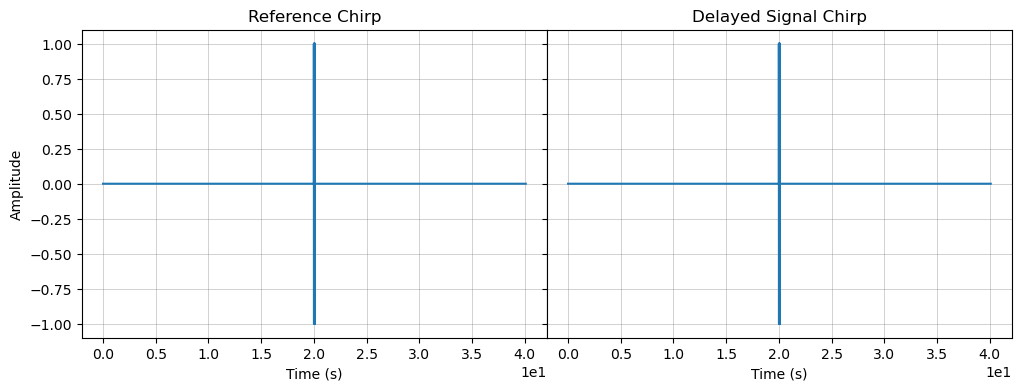

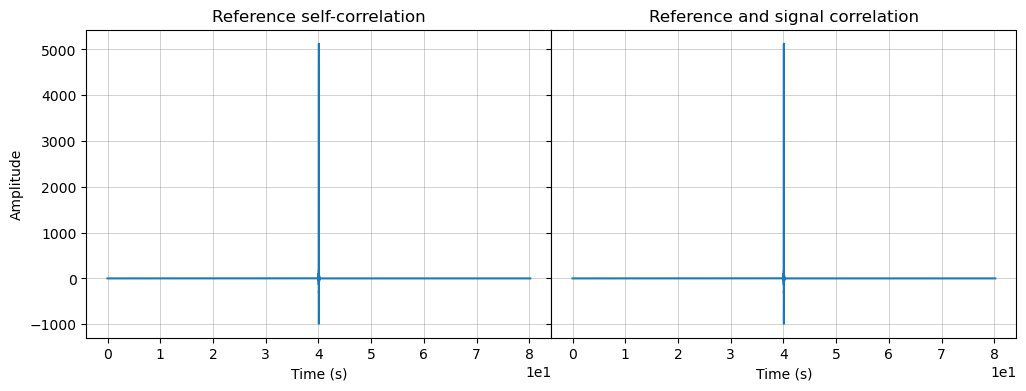

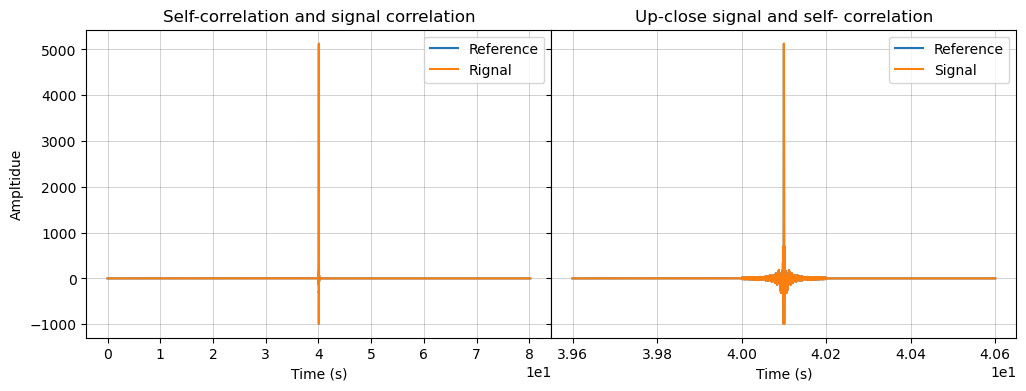

In [42]:
matched_filter_sim(samp_rate, chirp_maxfreq, pulse_T, delay = , repeat = 1, 
                   wait = 0, wait_noise = 0, sig_noise = (0,0),  plot = True)

220000
439999


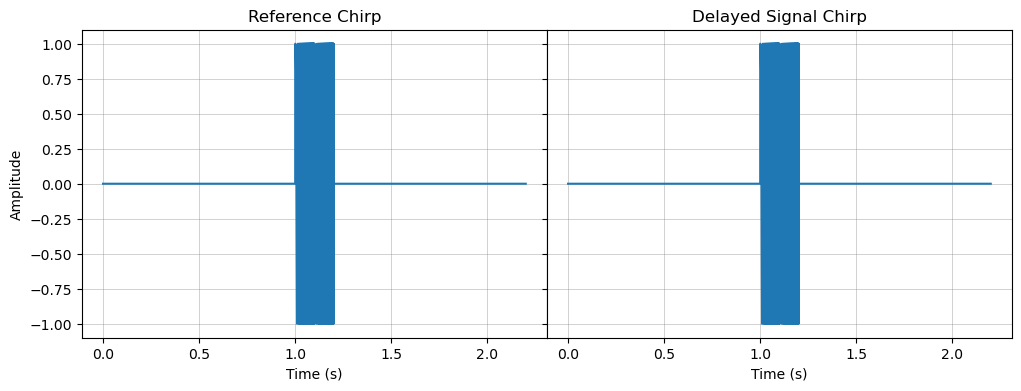

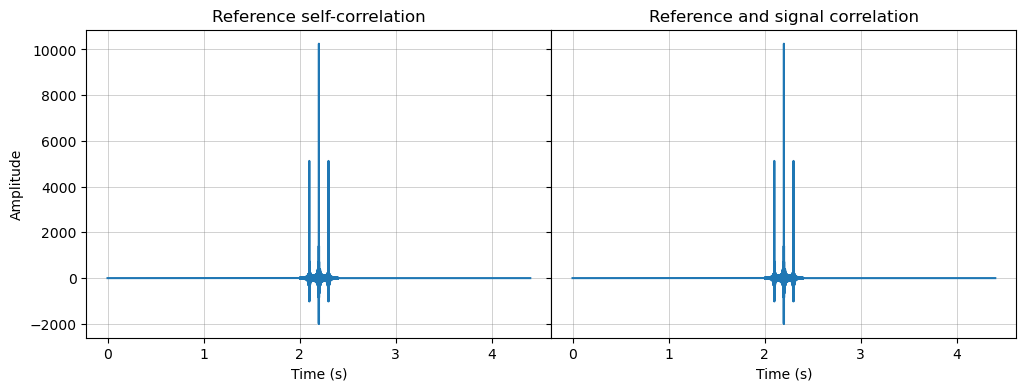

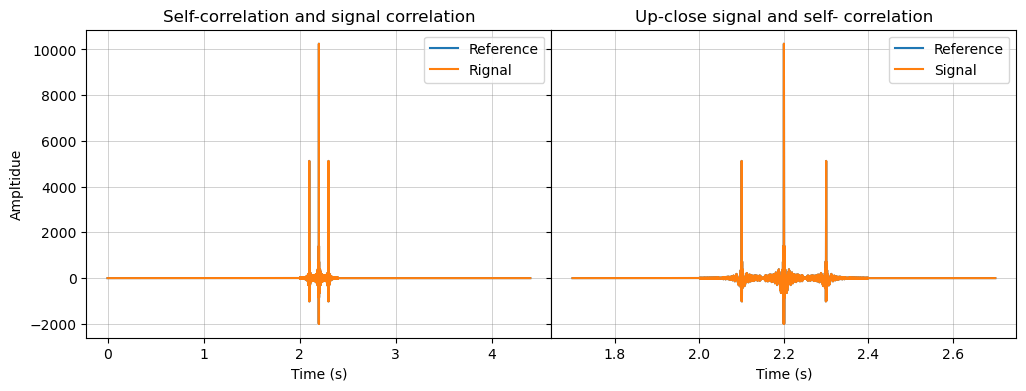

In [40]:
matched_filter_sim(samp_rate, chirp_maxfreq, pulse_T, delay = 0.5, repeat = 2, 
                   wait = 0, wait_noise = 0, sig_noise = (0,0),  plot = True)

250000
499999


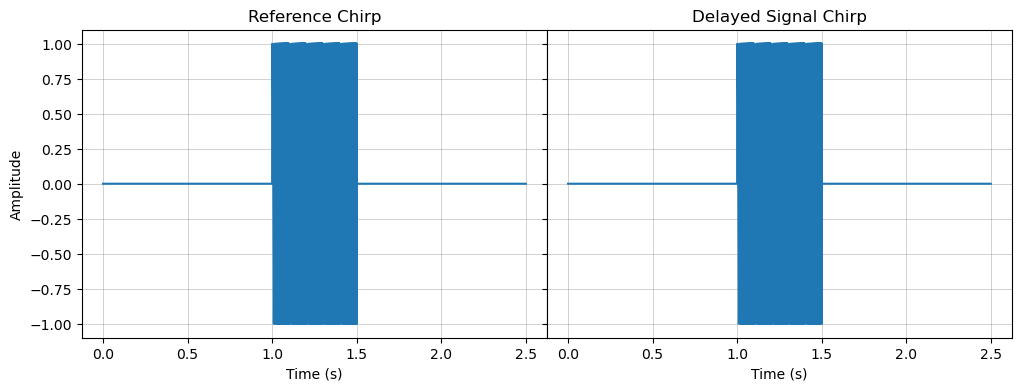

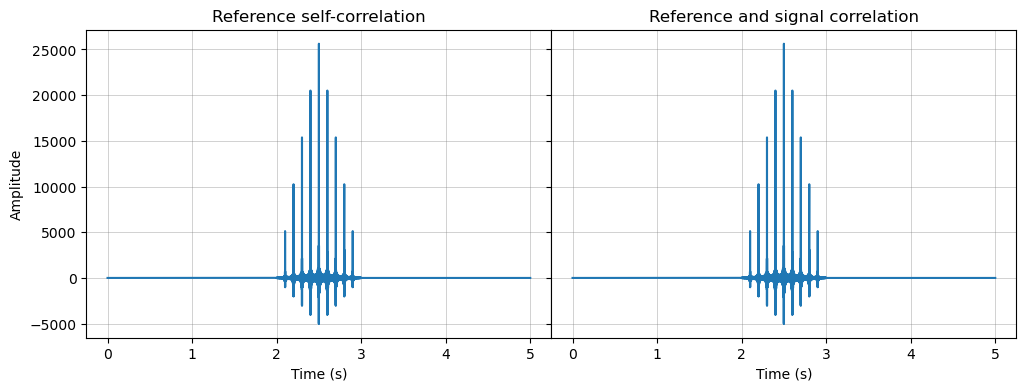

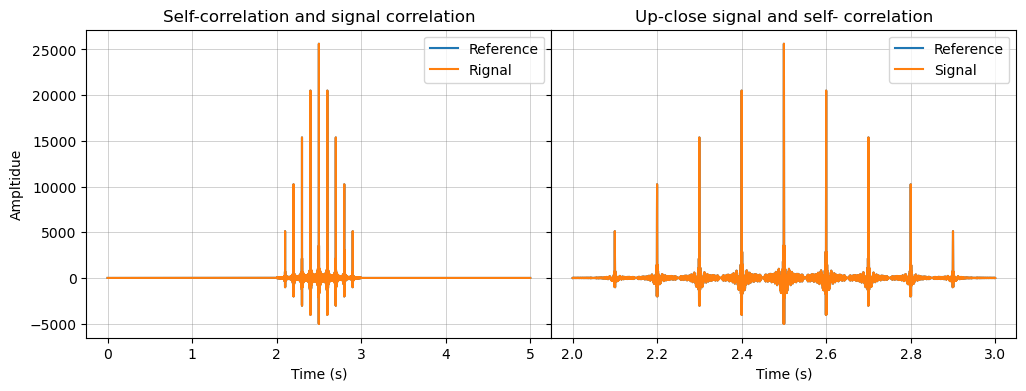

In [36]:
matched_filter_sim(samp_rate, chirp_maxfreq, pulse_T, delay = 0.5, repeat = 5, 
                   wait = 0, wait_noise = 0, sig_noise = (0,0),  plot = True)

300000
599999


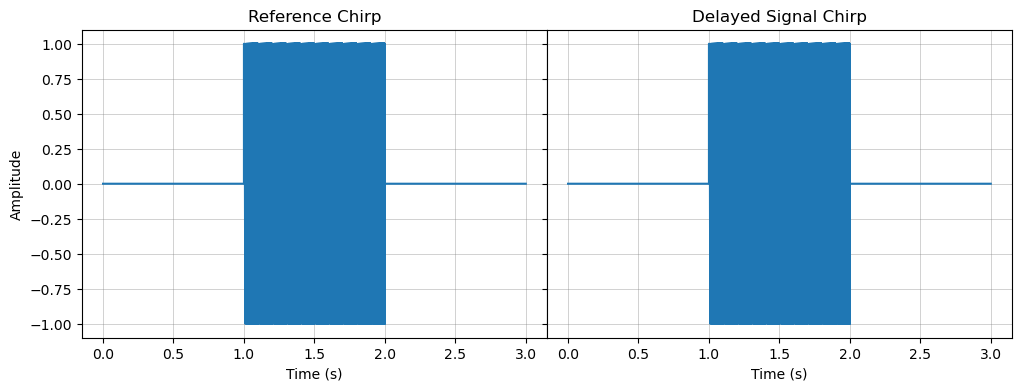

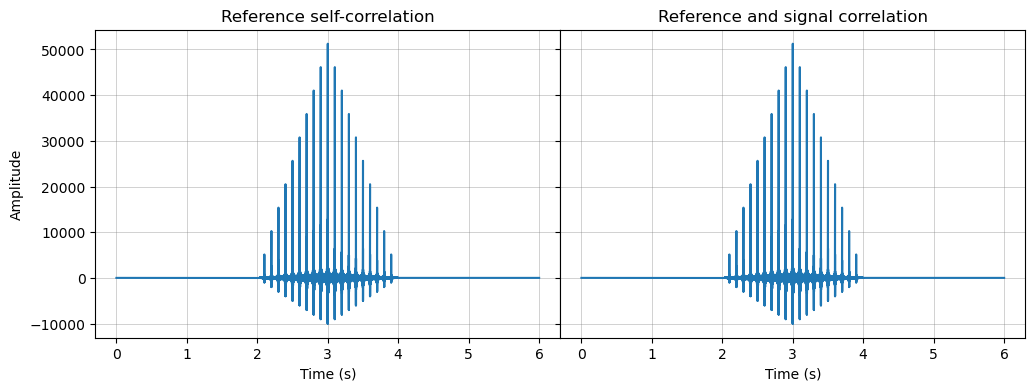

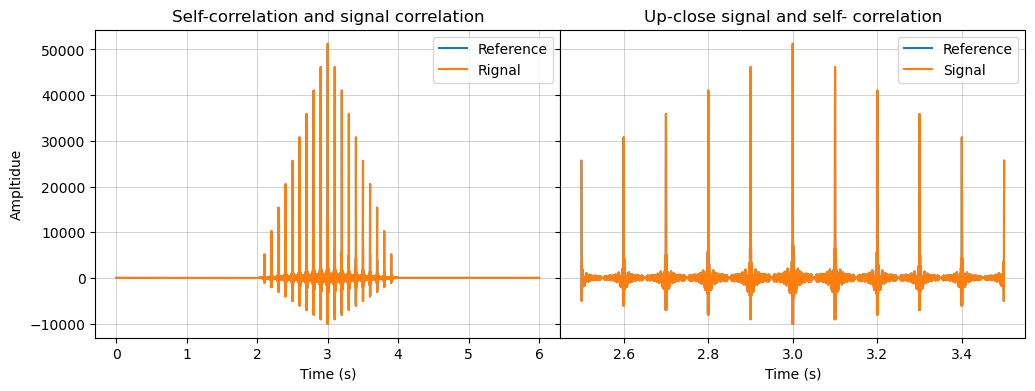

In [38]:
matched_filter_sim(samp_rate, chirp_maxfreq, pulse_T, delay = 0.5, repeat = 10, 
                   wait = 0, wait_noise = 0, sig_noise = (0,0),  plot = True)

700000
1399999


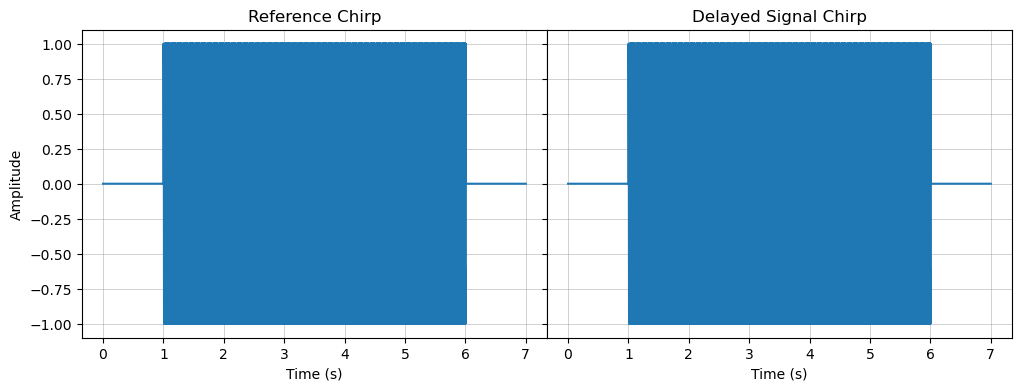

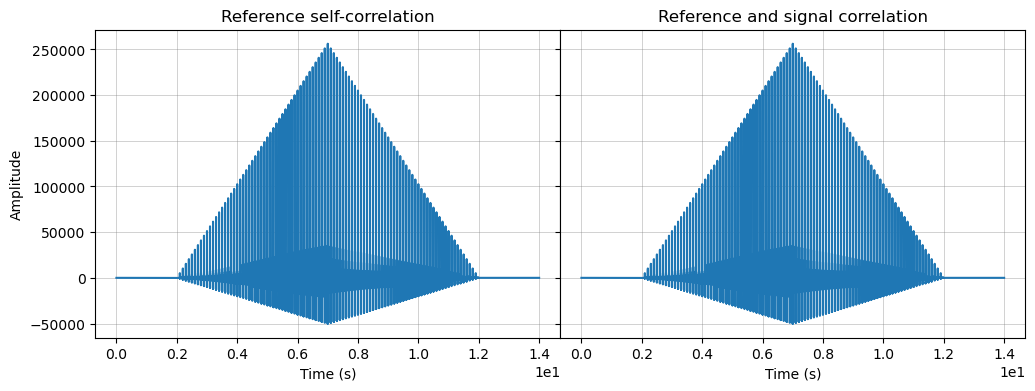

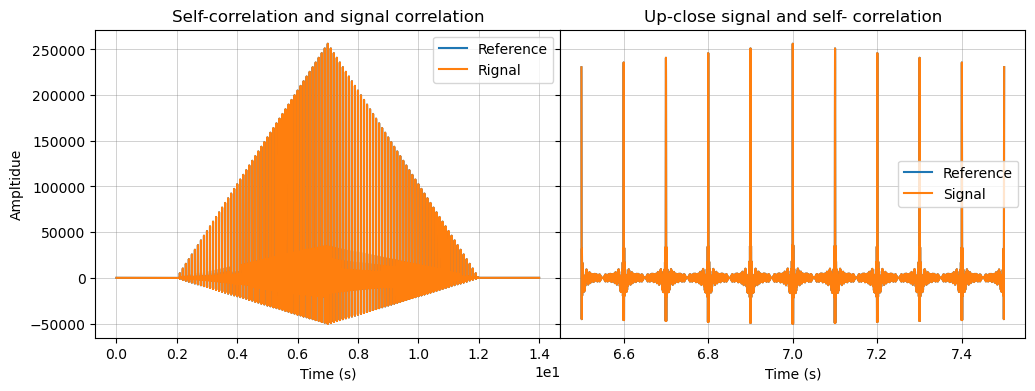

In [33]:
matched_filter_sim(samp_rate, chirp_maxfreq, pulse_T, delay = 0.5, repeat = 50, 
                   wait = 0, wait_noise = 0, sig_noise = (0,0),  plot = True)

10200000
20399999


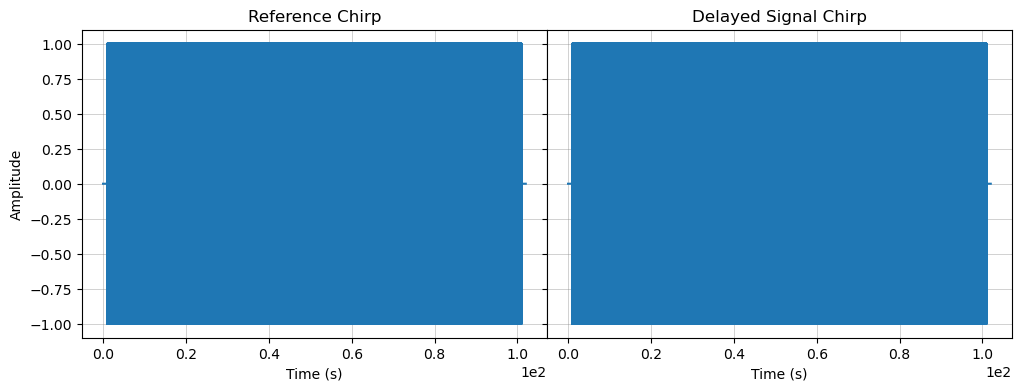

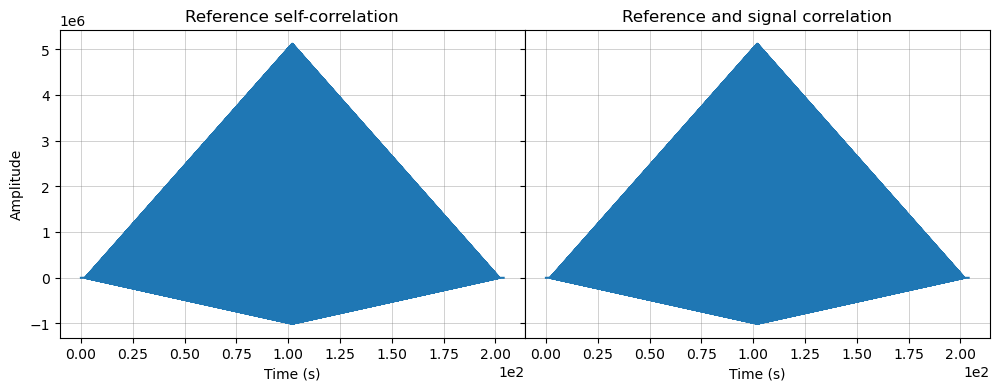

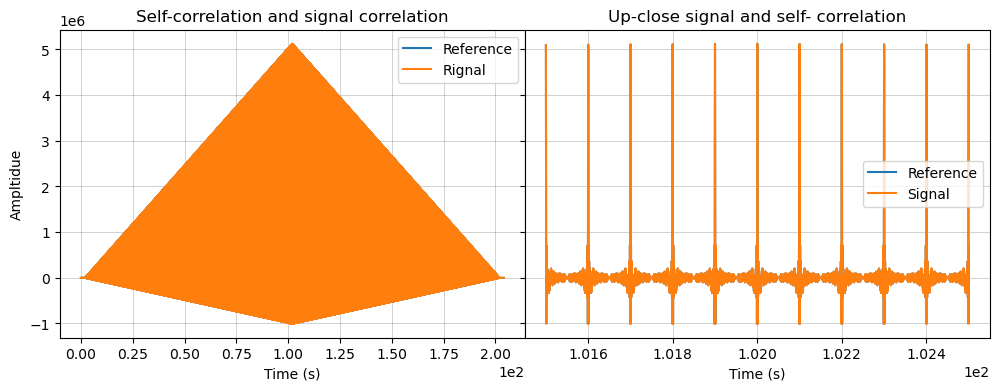

In [39]:
matched_filter_sim(samp_rate, chirp_maxfreq, pulse_T, delay = 0.5, repeat = 1000, 
                   wait = 0, wait_noise = 0, sig_noise = (0,0),  plot = True)